### Subtask 2b - Binary Classification 

#### Hardware Specs:
Computing Infrastructure:
- Apple M1 
- RAM size: 8gb

Software Environment:
- OS: macOS Sequoia (5.1.1)
- Python 3.9.6
- PyTorch 2.5.1

Training Details:
- Total training duration: ~ 22 minutes
- Average time per epoch: ~ 3-4 minutes

#### Necessary Imports

In [2]:
import os
import json
import numpy as np
import nltk
import spacy
from PIL import Image
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import stopwords
from torchvision import transforms
from collections import Counter
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import AutoTokenizer, DistilBertModel
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

/Users/maitreya/Documents/NEU/CS 6120 - NLP/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
# testing with apple metal processing shaders (mps)
#device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
#torch.set_default_device('mps')
device = torch.device("cpu")

In [172]:
print(torch.Generator(device=device).device)

cpu


##### Data Preprocessing

In [173]:
# Text preprocessing dependencies
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maitreya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [174]:
# Image Preprocessing
image_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [175]:
def clean_text(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if token.is_alpha and token.text.lower() not in stop_words]
    return " ".join(tokens)

#### Metric Tracking Class

In [176]:
class MetricTracker:
    def __init__(self):
        self.metrics = {
            'phase1': {'loss':[], 'macro_f1':[]},
            'phase2': {'loss':[], 'macro_f1':[]}
        }

    def add_metrics(self, phase:str, loss:float, macro_f1:float):
        self.metrics[phase]['loss'].append(loss)
        self.metrics[phase]['macro_f1'].append(macro_f1)
        

    def plot_metrics(self):
        plt.figure(figsize=(10,6))
        colors = ['#2E86C1', '#E74C3C']  # Blue for phase1, Red for phase2


        for idx, phase in enumerate(['phase1', 'phase2']):
            if len(self.metrics[phase]['loss']) > 0:
                epochs = range(1, len(self.metrics[phase]['loss']) + 1)
                plt.plot(
                    epochs,
                    self.metrics[phase]['loss'],
                    marker='o',
                    color=colors[idx],
                    label=f'{phase} Loss',
                    linestyle='-',
                    alpha=0.7
                )

                plt.plot(
                    epochs, 
                    self.metrics[phase]['macro_f1'],
                    marker='s',
                    color = colors[idx],
                    label = f'{phase} F1',
                    linestyle = '--',
                    alpha = 0.7
                )

        plt.title('Training Loss and Macro F1 Score Over Epochs', pad=20)
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    def plot_class_performance(self, final_report:str):
        lines = final_report.strip().split('\n')
        classes = []
        metrics = []

        for line in lines[2:4]:
            parts = line.split()
            classes.append(parts[0])
            metrics.append([float(x) for x in parts[1:4]]) # precision, recall, f1

        metrics = np.array(metrics)

        #plt.style.use('seaborn')
        fig, ax = plt.subplots(figsize=(10,6))

        x = np.arange(len(classes))
        width = 0.2

        colors = ['#AED6F1', '#F5B7B1', '#D2B4DE']

        bars1 = ax.bar(x - width, metrics[:, 0], width, label='Precision', 
                      color=colors[0], alpha=0.7, edgecolor='black', linewidth=1)
        bars2 = ax.bar(x, metrics[:, 1], width, label='Recall',
                      color=colors[1], alpha=0.7, edgecolor='black', linewidth=1)
        bars3 = ax.bar(x + width, metrics[:, 2], width, label='F1-score',
                      color=colors[2], alpha=0.7, edgecolor='black', linewidth=1)

        ax.set_ylabel('Scores', fontsize=12)
        ax.set_title('Performance Metrics by Classes', pad=20, fontsize=14)
        ax.set_xticks(x)
        ax.set_xticklabels(classes, rotation=45, ha='right')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.3)

        plt.tight_layout()
        plt.show()
        

#### Dataset class 

In [177]:
class MultimodalDataset(Dataset):
    def __init__(self, text_data, image_paths, labels, tokenizer, image_transform=None):
        self.text_data = text_data
        self.image_paths = image_paths
        self.labels = labels
        self.tokenizer = tokenizer
        self.image_transform = image_transform

    def __len__(self):
        return len(self.text_data)
    
    def __getitem__(self, idx):
        text = self.text_data[idx]
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        # Text processing
        encoded = self.tokenizer(
            text,
            padding = 'max_length',
            truncation = True,
            max_length = 128,
            return_tensors = "pt"
        )

        # Image Processing
        image = Image.open(image_path).convert("RGB")
        image = self.image_transform(image)

        return {
            "input_ids": encoded["input_ids"].squeeze(0),
            "attention_mask": encoded["attention_mask"].squeeze(0),
            "image": image,
            "label": torch.tensor(label, dtype=torch.float32)
        }

#### Classifier

In [ ]:
class MultimodalClassifier(nn.Module):
    def __init__(self):
        super(MultimodalClassifier, self).__init__()

        # Text encoder
        self.text_encoder = DistilBertModel.from_pretrained("distilbert-base-uncased")

        # Image encoder
        self.image_encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Linear(32 * 56 * 56, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512)
        )

        # projecting text embeddings to the same dim as image embeddings
        self.text_project = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3)
        )

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(512 * 2, 512), # Combining text and image features
            nn.BatchNorm1d(512),
            nn.Tanh(),               # Non linearity
            nn.Dropout(0.3),
            nn.Linear(512, 2),        # Attention weights for text and image 
            nn.Softmax(dim=1)
        )

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )


    def forward(self, input_ids, attention_mask, image):
        # text features : [batch_size, 768]
        text_features = self.text_encoder(input_ids = input_ids, attention_mask = attention_mask).last_hidden_state[:, 0, :] # [CLS] token
        
        # Projecting text features to same dimension as image features
        text_features = self.text_project(text_features) # [batch_size, 512]

        # Image features : [batch_size, 512]
        image_features = self.image_encoder(image)

        # Stacking features : [batch_size, 2, 512]
        combined_features = torch.cat((text_features, image_features), dim=1)
        
        # Attention weights
        attention_weights = self.attention(combined_features)  # [ batch_size, 2]

        # Adding L2 regularization to attention weights
        l2_reg = torch.norm(attention_weights, p=2, dim=1).mean()

        # Stacking features for weighted sum
        stacked_features = torch.stack([text_features, image_features], dim=1)  #[batch_size, 2, 512]

        # Applying attention weights
        # Reshaping weights to [batch_size, 2, 1] 
        attention_weights = attention_weights.unsqueeze(-1) #[batch_size, 2, 1]

        # Weighted sum of features
        fused_features = (stacked_features * attention_weights).sum(dim=1)

        return self.classifier(fused_features), l2_reg

In [179]:
# Evaluation
def evaluate_model(model, dataloader, device, threshold=0.5):
    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs, _ = model(input_ids, attention_mask, images)
            outputs = outputs.squeeze()
            preds.extend((torch.sigmoid(outputs) > threshold).int().cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return classification_report(true_labels, preds, target_names=["Non-Propagandistic", "Propagandistic"], digits=2)

In [180]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        return focal_loss.mean()

In [182]:
def load_data(json_path, image_dir):
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    texts = [entry['text'] for entry in data]
    image_paths = [os.path.join(image_dir, entry['image']) for entry in data]
    labels = [1 if entry.get('label') == 'propagandistic' else 0 for entry in data]
    return texts, image_paths, labels

In [183]:
def balanced_sampler(labels):
    labels = np.array(labels)
    class_counts = np.bincount(labels.astype(int))

    class_weights = np.array([
        1.0 / class_counts[0],
        0.5 / class_counts[1]
    ])

    sample_weights = class_weights[labels.astype(int)]
    sampler = WeightedRandomSampler(
        weights = torch.FloatTensor(sample_weights),
        num_samples = len(labels),
        replacement = True
    )

In [184]:
def get_metrics_from_report(report):
    try:
        lines = report.split('\n')
        lines = [line for line in lines if line.strip()] # empty lines skipped
        
        for line in lines:
            if line.strip().startswith('macro avg'):
                macro_line = line
            elif line.strip().startswith('weighted avg'):
                weighted_line = line.strip()

        macro_values = [val for val in macro_line.split() if val != 'macro' and val != 'avg']
        weighted_values = [val for val in weighted_line.split() if val != 'weighted' and val != 'avg']

        macro_f1 = float(macro_values[2])
        weighted_f1 = float(weighted_values[2])

        return macro_f1, weighted_f1


    except Exception as e:
        print(f"Error Parsing report: {e}")
        print(report)
        return 0.0, 0.0

In [ ]:
# Training the model on balanced data
def train_phase(model, train_loader, val_loader, optimizer, criterion, device, num_epochs, phase, metric_tracker):
    best_f1 = 0
    best_state = None
    patience = 3
    no_improve = 0
    min_delta = 0.01
    reg_lambda = 0.01

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_l2_reg = 0
        for batch in train_loader:
            optimizer.zero_grad()
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs, l2_reg = model(input_ids, attention_mask, images)
            outputs = outputs.squeeze()
            
            # combining losses
            loss = criterion(outputs, labels) +  reg_lambda*l2_reg
            total_l2_reg += l2_reg.item()
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)

        # Validation
        val_report = evaluate_model(model, val_loader, device)

        f1_macro, f1_weighted = get_metrics_from_report(val_report)

        # Tracking all metrics
        phase_key = 'phase1' if phase.startswith('Phase 1') else 'phase2'
        metric_tracker.add_metrics(
            phase=phase_key,
            loss = avg_loss,
            macro_f1 = f1_macro
        )

        if f1_macro > best_f1 + min_delta:
            best_f1 = f1_macro
            best_state = model.state_dict().copy()
            no_improve = 0
        else:
            no_improve += 1

        #f1 = float(val_report.split('\n')[-2].split()[-2])
        print(f" {phase} -> Epoch: {epoch+1}, Loss: {avg_loss:.3f}, Macro F1: {f1_macro:.3f}, Weighted F1: {f1_weighted:0.3f}")

        # saving the best model
        if no_improve >= patience:
            print(f"Early stopping triggered at epoch: {epoch+1}")
            break
    
    if best_state is not None:
        model.load_state_dict(best_state)
    return model, best_f1

In [ ]:
# Main training 
def tune_phase(train_dataset, val_dataset, train_labels, device, metric_tracker):
    # Initializing model
    model = MultimodalClassifier().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    class_counts = Counter(train_labels)
    alpha = class_counts[1] / class_counts[0]
    #pos_weight = torch.tensor([2.0 * class_counts[0] / class_counts[1]]).to(device)
    #criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    criterion = FocalLoss(alpha=alpha, gamma=2)
    
    print(f"Total Samples: {len(train_labels)}")
    print(f"Count of Non-Propagandistic: {class_counts[0]}")
    print(f"Count of Propagandistic: {class_counts[1]}")
    print(f"Alpha (weight) for Focal Loss: {alpha:.4f}")
    #print(f"Weight for Minority class (Non-Propagandistic): {pos_weight.item():.4f}")

    labels = torch.tensor(train_labels)
    class_weights = torch.FloatTensor([1.0/class_counts[0], 0.5/class_counts[1]])
    sample_weights = class_weights[labels]
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    
    bal_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=0, pin_memory=True)

    reg_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)

    # Validation loader
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)
    

    # Phase 1 - training on balanced data
    print("\n Phase 1: Training on Balanced Data") 
    model, phase1_f1 = train_phase(
        model, bal_loader, val_loader, optimizer, criterion, device, num_epochs=5, phase="Phase 1 - Balanced", metric_tracker=metric_tracker
    )

    # Phase 2 - Fine tuning on regular distribution
    print("\n Phase 2: Fine-tuning on Full Dataset") 
    model, phase2_f1 = train_phase(
        model, reg_loader, val_loader, optimizer, criterion, device, num_epochs=3, phase="Phase 2 - Fine Tune", metric_tracker=metric_tracker
    )

    print(f"\n Phase 1 -> F1 Score: {phase1_f1:.3f}")
    print(f"Phase 2 -> F1 Score: {phase2_f1:.3f}")

    return model

Total Samples: 1200
Count of Non-Propagandistic: 400
Count of Propagandistic: 800
Alpha (weight) for Focal Loss: 2.0000

 Phase 1: Training on Balanced Data
 Phase 1 - Balanced -> Epoch: 1, Loss: 0.293, Macro F1: 0.620, Weighted F1: 0.630
 Phase 1 - Balanced -> Epoch: 2, Loss: 0.239, Macro F1: 0.720, Weighted F1: 0.740
 Phase 1 - Balanced -> Epoch: 3, Loss: 0.182, Macro F1: 0.670, Weighted F1: 0.690
 Phase 1 - Balanced -> Epoch: 4, Loss: 0.144, Macro F1: 0.560, Weighted F1: 0.560
 Phase 1 - Balanced -> Epoch: 5, Loss: 0.109, Macro F1: 0.730, Weighted F1: 0.770
Early stopping triggered at epoch: 5

 Phase 2: Fine-tuning on Full Dataset
 Phase 2 - Fine Tune -> Epoch: 1, Loss: 0.158, Macro F1: 0.730, Weighted F1: 0.760
 Phase 2 - Fine Tune -> Epoch: 2, Loss: 0.062, Macro F1: 0.710, Weighted F1: 0.750
 Phase 2 - Fine Tune -> Epoch: 3, Loss: 0.040, Macro F1: 0.740, Weighted F1: 0.780

 Phase 1 -> F1 Score: 0.720
Phase 2 -> F1 Score: 0.730


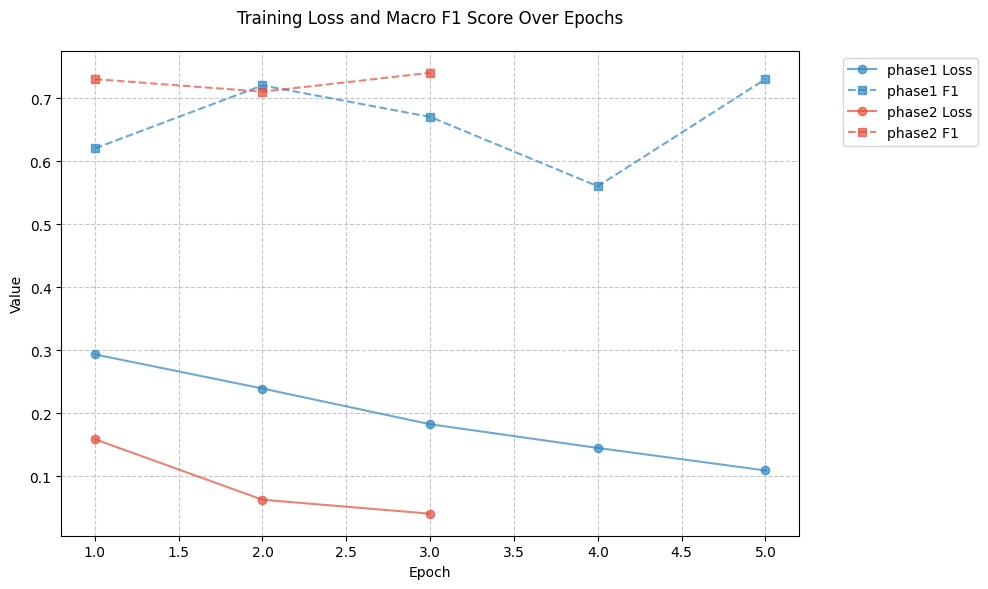


 Evaluation Report: 

                    precision    recall  f1-score   support

Non-Propagandistic       0.75      0.54      0.63        50
    Propagandistic       0.80      0.91      0.85       100

          accuracy                           0.79       150
         macro avg       0.77      0.73      0.74       150
      weighted avg       0.78      0.79      0.78       150


Class wise performance: 


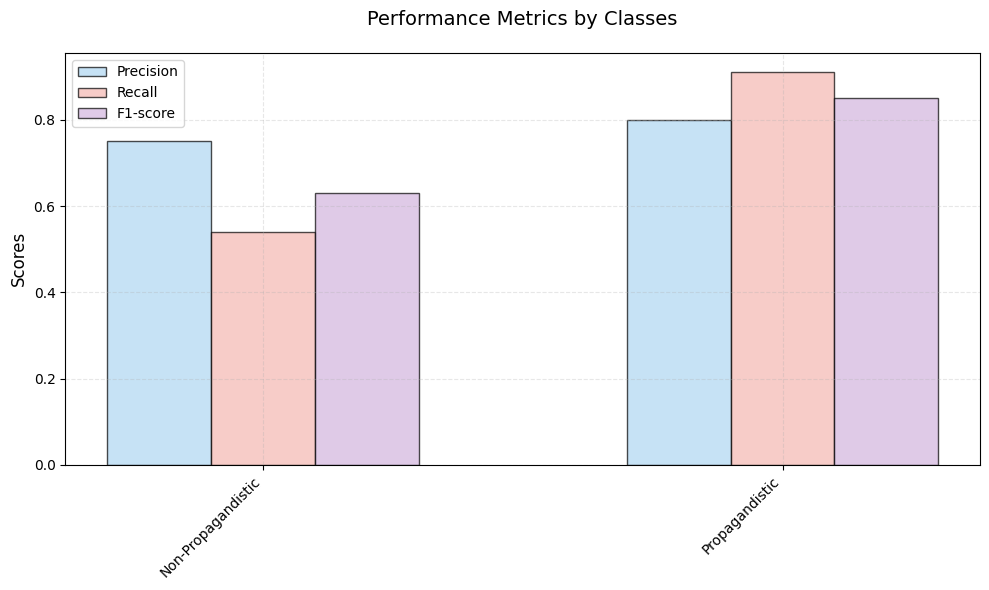

In [ ]:
if __name__ == "__main__":
    # Data setup
    tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
    image_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Loading data
    train_texts, train_image_paths, train_labels = load_data(
            '/Users/maitreya/Documents/NEU/CS 6120 - NLP/Project/data/semeval2024_dev_release/subtask2b/train.json',
            '/Users/maitreya/Documents/NEU/CS 6120 - NLP/Project/data/subtask2b_images/train'
    )

    val_texts, val_image_paths, val_labels = load_data(
            '/Users/maitreya/Documents/NEU/CS 6120 - NLP/Project/data/semeval2024_dev_release/subtask2b/val.json',
            '/Users/maitreya/Documents/NEU/CS 6120 - NLP/Project/data/subtask2b_images/val'
    )

    # Creating datasets
    train_dataset = MultimodalDataset(
        train_texts, train_image_paths, train_labels, tokenizer, image_transform
    )

    val_dataset = MultimodalDataset(
        val_texts, val_image_paths, val_labels, tokenizer, image_transform
    )

    # Initializing metric tracker 
    metric_tracker = MetricTracker()

    # Training Model
    train_model = tune_phase(
        train_dataset = train_dataset,
        val_dataset=val_dataset,
        train_labels=train_labels,
        device=device,
        metric_tracker=metric_tracker
    )

    # Plotting Loss and F1
    metric_tracker.plot_metrics()

    # Evaluation
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    report = evaluate_model(train_model, val_loader, device)
    print("\n Evaluation Report: \n")
    print(report)

    print(f"\nClass wise performance: ")
    metric_tracker.plot_class_performance(report)

#### Example check 

In [190]:
def predict_single_image(model, tokenizer, image_path, text, image_transform, device):
    model.eval()

    image = Image.open(image_path).convert("RGB")
    image = image_transform(image).unsqueeze(0).to(device)

    encoded_text = tokenizer(text, padding=True, truncation=True, max_length=123, return_tensors="pt")

    input_ids = encoded_text["input_ids"].to(device)
    attention_mask = encoded_text["attention_mask"].to(device)

    # Get predictions
    with torch.no_grad():
        output, _ = model(input_ids, attention_mask, image)
        prediction = (torch.sigmoid(output.squeeze()) > 0.5).long()

    return prediction.item()

##### Testing with single image:

In [191]:
image_path = "/Users/maitreya/Documents/NEU/CS 6120 - NLP/Project/data/subtask2b_images/val/prop_meme_15428.png"
text = "Thank you!\\nfor signing the\\nTERM LIMITS ON\\nCONGRESS\\nPLEDGE\\nU.S. Term Limits Pledge\\nI, Rick Lindsay, pledge that as a member of the state\\nlegislature I will cosponsor, vote for, and defend the\\nresolution applying for an Article V convention for the sole\\npurpose of enacting term limits on Congress.\\ntermlimits.com/pledge\\nRick Lindsay\\n(Signature, Date)\\nRisk\\n(Name Printed)\\nU.S.\\nTERM\\nLIMITS\\n(Witness Signature)\\n(Witness Name Printed)\\nU.S. Term Limits/ ago Connecticut Ave NW, Suite zoo/ Washington, D.C. 20036\\nPhone: 200-261-3332 Pledges can be emailed to Press@termlimits.com\\nU.S.\\nRick Lindsey\\nTERM\\nLIMITS Candidate for Kansas State House District 86"

prediction = predict_single_image(train_model, tokenizer, image_path, text, image_transform, device)
if prediction > 0:
    print(f"Propagandistic")
else:
    print(f"Non-Propagandistic")

Propagandistic
